In [2]:
import pyjags
"""
imports for custom handler module. these functions manage model
parameters and visualization. 
include scipy, pandas, numpy, matplotlib.
"""
from pjbcmassistant import model_spec
from pjbcmassistant import visualizer

In [3]:
model_handler = model_spec(model="Rate_1.txt")

In [6]:
# very basic pyjags use case.
# have not yet settled on a sensible way to do data/model/initial values imports.

nchains = 2
nsamples = 10000

k = 9
n = 10

model_handler = model_spec(model="Rate_1.txt")



model = pyjags.Model(code=model_handler.model, data=dict(k=k, n=n), chains=nchains, init=None)
samples = model.sample(nsamples, vars=['theta','k'])

#insert a credible interval function here, once that's resolved.
    


adapting: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 20000 of 20000, elapsed 0:00:00, remaining 0:00:00


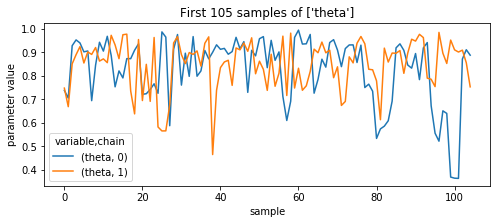

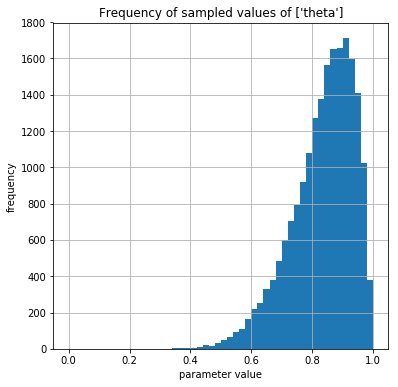

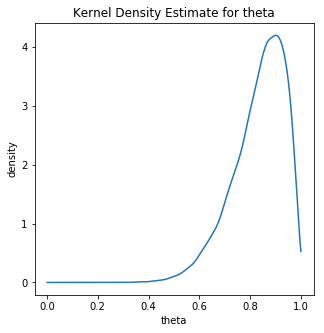

maximum density observed across 1000 bins was at x = 0.901


In [7]:
viz = visualizer(samples)

viz.chains('theta', range=105)
viz.hist('theta')
viz.kde('theta', showmax=True)

I'm getting a 95% CI here that doesn't match the analytic result. Process was lifted from the `pyjags` docs. It looks as though the author of the `pyjags` module may be using quantiles to produce credibiilty intervals, where per this conversation at [stackexchange](https://stats.stackexchange.com/questions/240749/how-to-find-95-credible-interval) the preferred method is to look for the HPD, highest posterior density interval.

Tabling that question until the end of this doc.



## Plotting chains, parameter frequency, and KDEs

I made a module for handling plotting, all of these functions have been moved over there.


Below is code for producing (a subsection of) the chains plots, the frequency of sampled values of $\theta$, and a kernel density estimate plot.

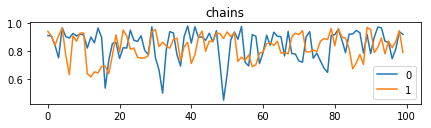

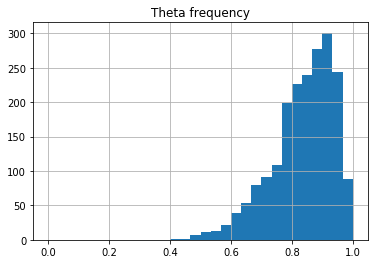

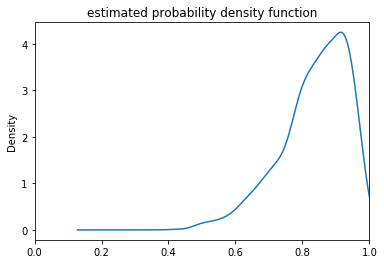

In [11]:
#convert our chains to a dataframe for processing/display
df = pd.DataFrame(samples['theta'][0])

#plot the chains
df[0:100].plot(figsize=(7,1.5))
plt.title("chains")
plt.show()


#'melt' stacks all chain columns into a single value column, hist plots this
#new column of values.
df.melt()['value'].hist(range=(0, 1), bins=30, label="Theta PDF")
plt.title('Theta frequency')
plt.show()

#plot the KDE using built-in pandas functionality
df.melt()['value'].plot.kde()
plt.xlim((0,1))
plt.title('estimated probability density function')
plt.show()


As seen above, plotting a kernel density estimate is simple enough.


#### finding MLE
Finding the approximate maximum value, as below, appears somewhat more involved, and requires generating the KDE function with `scipy`.
[stackoverflow reference](https://stackoverflow.com/questions/31248913/how-to-estimate-density-function-and-calculate-its-peaks)


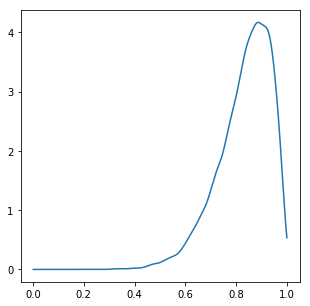

maximum density observed across 1000 bins was at x = 0.887


In [9]:
#use scipy to generate KDE function from a numpy array pulled from the dataframe
nparam_density = scipy.stats.gaussian_kde(viz.df['theta'].values.ravel())

#generate a linear space for the function to be calculated over
x = np.linspace(0.001,1,1000)

#plot x against kde(x)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, nparam_density(x), label='non-parametric density (smoothed by Gaussian kernel)')

plt.show()

#sort densities from smallest to largest, and print the x value of the largest.
max_density = x[np.argsort(nparam_density(x))[-1]]
print(f"maximum density observed across 1000 bins was at x = {max_density}")


todo: render frequency as estimated density function.

## Mucking around with Credibility Intervals

### or, "something has gone wrong"

The below script was lifted from [stats stack exchange](https://stats.stackexchange.com/questions/252988/highest-density-interval-in-stan) ... But we're still not getting the same values as the analytic results in the book, `CI 0.59 to 0.89`

In [6]:
#in theory, this should produce a the desired HPD interval for unimodal data...

#this checks every contiguous interval in the list of samples from the posterior that
#contains 95% of the data, and determines which is the narrowest, then
#returns that interval's upper and lower bounds.

df = pd.DataFrame(samples['theta'][0])

def computeHDI(chain, interval = .95):
      # sort chain using the first axis which is the chain
    chain.sort()
      # how many samples did you generate?
    nSample = chain.size 
    print(f'number of samples: {nSample}')
      # how many samples must go in the HDI?
    nSampleCred = int(np.ceil(nSample * interval))
    print(f'width of intervals tested: {nSampleCred}')
      # number of intervals to be compared
    nCI = nSample - nSampleCred
    print(f'number of intervals tested: {nCI}')
      # width of every proposed interval
    width = np.array([chain[i+nSampleCred] - chain[i] for  i in range(nCI)])
    #print(width)
      ## index of lower bound of shortest interval (which is the HDI) 
    best  = width.argmin()
      # put it in a dictionary
    HDI   = {'Lower': chain[best], 'Upper': chain[best + nSampleCred], 'Width': width.min()}
    return HDI

computeHDI(df.values.ravel())

number of samples: 20000
width of intervals tested: 19000
number of intervals tested: 1000


{'Lower': 0.632703529234288,
 'Upper': 0.9935744625220517,
 'Width': 0.36087093328776376}

Below is separate script, lifted from [a bayesian data analysis project on github](https://github.com/aloctavodia/Doing_bayesian_data_analysis/blob/master/hpd.py) that yields the same values as above.

Problem is unlikely to reside in poor definition/execution of HPD. More likely a different sort of confidence interval was used to produce book values, or else the model here is not the same as produced their results.

Will check these methods against some of the results from the `pymc3` port, where HPD was supplied explicitly.

In [7]:
def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max

def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
    return np.array(calc_min_interval(sx, alpha))

hpd(df.values.ravel())

array([0.63270353, 0.99357446])